# Анализ мошенничества с кредитными картами
<br>**Описание задачи**
<br>Данные представляют собой транзакции, совершенные с помощью кредитных карт в сентябре
2013 года европейскими держателями карт. <br>В датасете содержится информация о 284,807
транзакциях, включая 492 случая мошенничества, что составляет 0.172% от общего числа
транзакций. <br>Данные представлены числовыми переменными, полученными в результате
преобразования методом главных компонент (PCA). <br>Оригинальные признаки и подробности о
данных не предоставлены из соображений конфиденциальности. <br>Признаки V1-V28 являются
результатом PCA, <br>'Time' содержит время в секундах между транзакцией и первой записью,
<br>а 'Amount' обозначает сумму транзакции.

**Ход решения**

1. Корреляционный анализ:     - Рассчитать корреляционную матрицу для числовых переменных
    - Возвращаемый тип данных - numpy массив с размерностью 2.
      
2. Проверка статистических гипотез          - Проверить гипотезы, например, о равенстве средних сумм для признав     
  - Параметры включают признаки для сравнения, критерий проверки (t-test, z-test, kolmogorov-smirnov, fisher) и уровень значимос
      ти.
3. Точечные оценки параметров распрени         
  - Оценить средние и дисперсии для выбранных признаков с использованием метода моментов и метода максимального правдопод        . 
  - Возвращаемый тип данных - строка с оце
      нка Определение влияния признаков на безопасность транзакции:     ии: 
  - Применить логистическую регрессию для выявления признаков, оказывающих наибольшее влияние на безопасность тра        ций. 
  - Возвращаемый тип данных - список с названиями признаков на основе весов в логистической регрессии, ограниченный top_k пар
      аметрами.
5. ые вальн       ценки: 
  - Рассчитать доверительные интервалы для среднего значения выбранного признака с учетом уровня         имости. 
  - Использовать t- или z-статистику в зависимости от размера выборки (подсказка: центральная предельная теорема и з        ние 30). 
  - Возвращаемый тип данных - tuple с интервальной оценкой в формате (lower_bound, upper_bound).

### Импорт библиотек

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats
from matplotlib import pyplot as plt
from phik.report import plot_correlation_matrix
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings('ignore')

from CreditCardFraudAnalysis import CreditCardFraudAnalysis

## Знакомство с данными

In [2]:
df = pd.read_csv('creditcard.csv')
df.info()
df.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
156694,108714.0,-0.512880,0.847099,2.402880,-0.117556,0.177554,-0.243833,0.591797,-0.288000,1.417276,...,-0.291306,-0.360625,-0.284239,-0.100845,0.274202,-0.727136,-0.075657,-0.144328,11.27,0
147368,88471.0,-0.518596,0.056019,-0.017785,-1.057610,1.949265,0.250774,1.334047,-0.663379,0.475714,...,-0.497870,-0.555940,0.324365,-0.420567,-0.354381,0.065356,-0.525726,-0.630114,9.03,0
282169,170704.0,-6.737052,-3.499752,-1.413603,-0.174386,-0.657434,0.601857,2.320150,-1.015877,2.729242,...,-1.300983,0.872928,-0.858319,-0.691938,0.373744,0.116594,0.146117,1.946575,500.00,0


Соотношение меток в целевом признаке

In [3]:
print(df['Class'].value_counts())
df['Class'].value_counts()[1] / df['Class'].value_counts()[0]

Class
0    284315
1       492
Name: count, dtype: int64


0.0017304750013189597

## EDA

### 1. Проверка корреляции между данными

interval columns not set, guessing: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


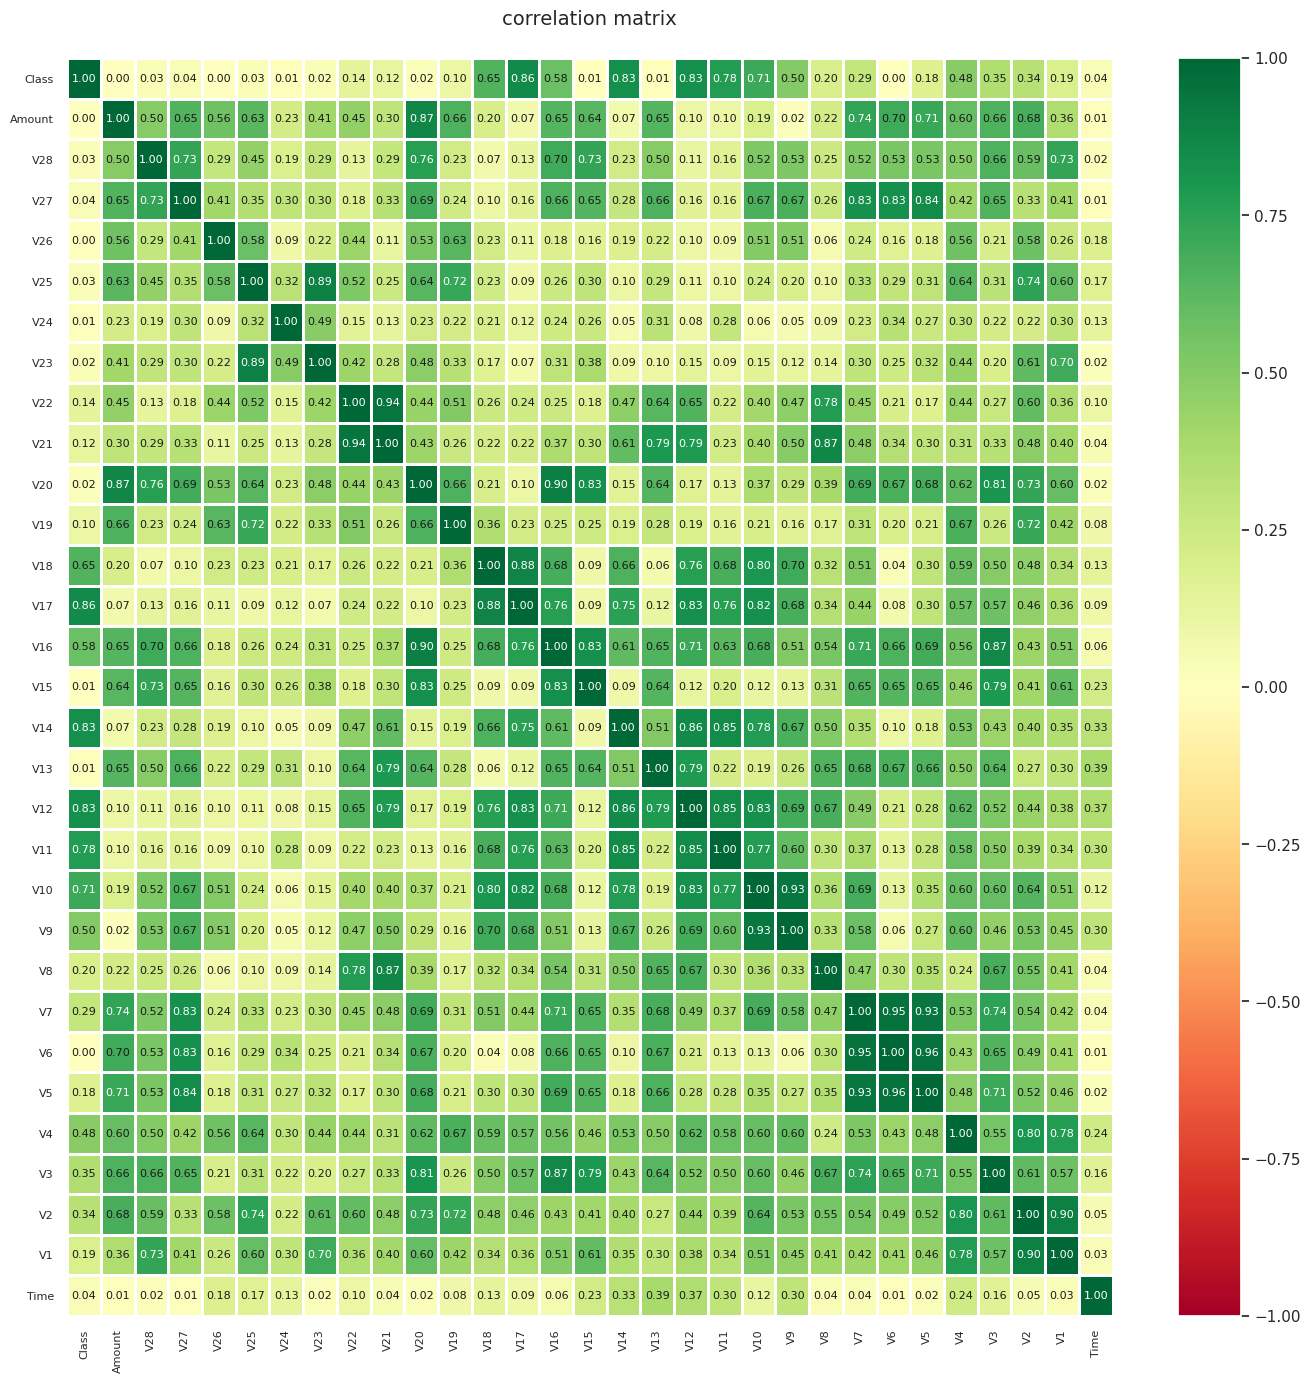

In [4]:
phik_overview = df.phik_matrix()
sns.set()
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=-1, 
                        vmax=1,
                        fontsize_factor=.8, 
                        figsize=(14, 14)
                       )
plt.title('correlation matrix', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [5]:
correlation_matrix = np.corrcoef(df, rowvar=False)

Выводы:
- на построенной матрице можно отследить силу и направление связи между признаками;
- в предоставленных данных обратной корреляции не наблюдается;
- между некоторыми признаками можно выделить сильные зависимости, например:
  - V1 и V2
  - V3 и V16
  - V5 и V7, V5 и V6, V5 и V27
- у других признаков практически не наблюдается каких-либо зависимостей, например:
  - Time, V24, V8

### 2. Проверка статистических гипотез

In [6]:
alpha = 0.05 # установка уровня значимости

#### H0: средние значения признаков V5 и V7 равны

In [7]:
t_statistic, p_value_t = stats.ttest_ind(df['V5'], df['V7'])
print(f"t-статистика: {round(t_statistic, 3)}")
print(f"p-значение для t-критерия: {round(p_value_t, 3)}")
if p_value_t < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

t-статистика: 0.0
p-значение для t-критерия: 1.0
Не получилось отвергнуть нулевую гипотезу


#### H0: дисперсии признаков Class и Amount равны

In [8]:
f_statistic, p_value_f = stats.levene(df['Class'], df['Amount'])
print(f"f-статистика: {round(f_statistic, 3)}")
print(f"p-значение для f-критерия: {round(p_value_f, 3)}")
if p_value_f < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

f-статистика: 30968.738
p-значение для f-критерия: 0.0
Отвергаем нулевую гипотезу


Выводы:
- проведённый тест Стьюдента не даёт весомых оснований, чтобы отвергнуть нулевую гипотезу о равенстве средних `V5` и `V7`
- проведённый тест Фишера позволяет отвергнуть нулевую гипотезу о равенстве дисперсии признаков `Class` и `Amount`

### 3. Точечные оценки параметров распределения

Посмотрим среднее и дисперсию целевого признака

In [9]:
target_mean = df['Class'].mean()
target_var = df['Class'].var()
print(f"среднее значение: {target_mean}\nдисперсия: {target_var}")

среднее значение: 0.001727485630620034
дисперсия: 0.001724507479019877


Выводы:
- посчитано среднее значение целевого признака
- посчитана дисперсия целевого признака

### 4. Определение влияния признаков на безопасность транзакции

In [10]:
X = df.drop(columns=['Class'])
y = df['Class']

# Обучение логистической регрессии
model_lr = LogisticRegression()
model_lr.fit(X, y)

# Получение коэффициентов влияния признаков
feature_importances = abs(model_lr.coef_[0])

# Сортировка признаков по влиянию
sorted_features = [feature for _, feature in sorted(zip(feature_importances, X.columns), reverse=True)]

# Возвращение top 3 признаков
print(f"три наиболее важных признака: {sorted_features[:3]}")

три наиболее важных признака: ['V14', 'V17', 'V1']


Выводы:
- обучена модель логистической регрессии
- определена важность признаков
- выделены три наиболее важных признака: V14, V17, V1

### 5. Интервальные оценки

Посмотрим доверительный интервал признака Amount

In [11]:
confidence_interval = stats.norm.interval(1-alpha, loc=np.mean(df['Amount']), scale=stats.sem(df['Amount']))
print("95% Доверительный интервал для среднего:",confidence_interval)

95% Доверительный интервал для среднего: (87.43102997465593, 89.26820852720672)


Выводы:
- произведён расчёт 95%-го доверительного интервала для признака `Amount`

## Проверка работоспособности класса `CreditCardFraudAnalysis`

In [12]:
# создание экземпляра класса
analysis = CreditCardFraudAnalysis(df)

# 1. проверка матрицы корреляции
result_correlation_matrix = analysis.correlation_task()
print(f'размерность матрицы корреляций: {result_correlation_matrix.shape}')

# 2. проверка статистического метода
result_stat_hypotheses = analysis.test_hypotheses(feature1='V5', 
                                                  feature2='V7', 
                                                  test_criteria='t-test', 
                                                  alpha=0.05)
print(result_stat_hypotheses)

# 3. проверка точечных оценок параметров распределения
result_point_est_param = analysis.point_estimates_parameters('Class')
print(result_point_est_param)

# 4. проверка определения влияния признаков на безопасность транзакции
result_impact_on_security = analysis.impact_on_security(3)
print(result_impact_on_security)

# 5. проверка интервальной оценки
result_interval_estimates = analysis.interval_estimates('Amount', 0.95)
print(result_interval_estimates)

размерность матрицы корреляций: (30, 30)
t-test: верна H0
Среднее: 0.001727485630620034, Дисперсия: 0.001724507479019877
['V14', 'V17', 'V1']
(88.32023005081194, 88.37900845105071)


## Выполнение:
+ Корреляционный анализ
+ Проверка статистических гипотез
+ Точечные оценки параметров распределения
+ Определение влияния признаков на безопасность транзакции
+ Интервальные оценки